# Hyperparameter Optimization Techniques
1. GridSearchCV
2. RandomizedSearchCV
3. Bayesian Optimization - Automate Hyperparameter Tuning (Hyperopt)
4. Sequential Model Based Optimization(Tuning a scikit-learn estimator with skopt)
5. Optuna - Automate Hyperparameter Tuning
6. Genetic Algorithms (TPOT Classifier)

## Importing Required Libraries

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, confusion_matrix
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
!pip install tpot --quiet
from tpot import TPOTClassifier
!pip install optuna --quiet
import optuna
import sklearn.svm
import warnings

## Importing the Dataset
> The dataset has been downloaded from `PIMA Diabetes` dataset, `kaggle` datasets

In [ ]:
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv('./diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


> From `describe()` function we can observe that for the columns 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', the `minimum` value is `0` which is not appropriate. We will replace those `0`s with `median` value of the respected column.

In [12]:
col_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def impute_zero(df, col_list):
    for col in col_list:
        df[col] = np.where(df[col] == 0, df[col].median(), df[col])

impute_zero(df, col_list)

In [13]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## Extracting Dependent and Independent Features

In [14]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [15]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,30.5,33.6,0.627,50
1,1,85.0,66.0,29.0,30.5,26.6,0.351,31
2,8,183.0,64.0,23.0,30.5,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [16]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

## Splitting the dataset into Training and Testing sets

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

## Fitting the preliminary model and testing the metrics

In [19]:
rf_clf = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [21]:
accuracy_score(y_test, y_pred)

0.7142857142857143

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79        99
           1       0.62      0.51      0.56        55

    accuracy                           0.71       154
   macro avg       0.69      0.67      0.67       154
weighted avg       0.71      0.71      0.71       154



In [24]:
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

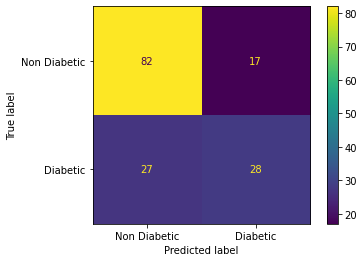

In [26]:
plot_confusion_matrix(rf_clf, X_test, y_test, display_labels=['Non Diabetic', 'Diabetic'], values_format='d')

> ## The main parameters used by a RandomForestClassifier are:
- `Criterion`: The function used to evaluate the quality of a split
- `max_depth`: Maximum no.of levels allowed in each tree
- `max_features`: Maximum no.of features considered when splitting a node
- `min_samples_leaf`: Minimum no.of samples which can be soted in a tree leaf
- `min_samples_split`: Minimum no.of samples necessary in a node to cause node splitting
- `n_estimators` = No.of trees in the ensemble

> ### Manual Hyperparameter Tuning

In [31]:
model = RandomForestClassifier(n_estimators=300, 
                               criterion='entropy', 
                               max_features='sqrt', 
                               min_samples_leaf=10, 
                               random_state=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)            

In [32]:
accuracy_score(y_test, y_pred)

0.7467532467532467

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82        99
           1       0.70      0.51      0.59        55

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



In [36]:
confusion_matrix(y_test, y_pred)

array([[87, 12],
       [27, 28]])

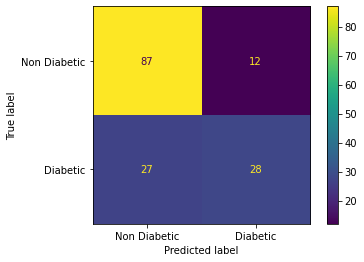

In [37]:
plot_confusion_matrix(model, X_test, y_test, display_labels=['Non Diabetic', 'Diabetic'], values_format='d')

## Hyperparameter Optimization using RandomizedSearchCV
> RandomizedSearchCV narrows down our search results

In [39]:
# Defining Parameters
random_params = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                 'criterion': ['entropy', 'gini'],
                 'max_features': ['auto', 'sqrt', 'log2'],
                 'max_depth': [int(x) for x in np.linspace(10, 1000, 10)],
                 'min_samples_split': [1, 2, 3, 4, 5, 7, 9],
                 'min_samples_leaf': [1, 2, 4, 6, 8]
                 }

In [41]:
print(random_params)

dict_items([('n_estimators', [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]), ('criterion', ['entropy', 'gini']), ('max_features', ['auto', 'sqrt', 'log2']), ('max_depth', [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]), ('min_samples_split', [1, 2, 3, 4, 5, 7, 9]), ('min_samples_leaf', [1, 2, 4, 6, 8])])


In [43]:
clf = RandomForestClassifier()
random_cv = RandomizedSearchCV(clf, param_distributions=random_params, n_iter=100, 
                               cv=3, verbose=2, random_state=100, n_jobs=-1)
random_cv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [44]:
random_cv.best_params_

{'criterion': 'gini',
 'max_depth': 120,
 'max_features': 'log2',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 400}

In [45]:
random_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=120, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
best_random_cv = random_cv.best_estimator_

In [47]:
y_pred = best_random_cv.predict(X_test)

In [48]:
accuracy_score(y_test, y_pred)

0.7467532467532467

## Hyperparameter Optimization using GridSearchCV

In [54]:
param_grid = {
    'criterion': [random_cv.best_params_['criterion']],
    'max_depth': [random_cv.best_params_['max_depth']],
    'max_features': [random_cv.best_params_['max_features']],
    'min_samples_leaf': [random_cv.best_params_['min_samples_leaf'], 
                         random_cv.best_params_['min_samples_leaf']+2, 
                         random_cv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [random_cv.best_params_['min_samples_split'] - 2,
                          random_cv.best_params_['min_samples_split'] - 1,
                          random_cv.best_params_['min_samples_split'], 
                          random_cv.best_params_['min_samples_split'] +1,
                          random_cv.best_params_['min_samples_split'] + 2],
    'n_estimators': [random_cv.best_params_['n_estimators'] - 200, random_cv.best_params_['n_estimators'] - 100, 
                     random_cv.best_params_['n_estimators'], 
                     random_cv.best_params_['n_estimators'] + 100, random_cv.best_params_['n_estimators'] + 200]
}

print(param_grid)

{'criterion': ['gini'], 'max_depth': [120], 'max_features': ['log2'], 'min_samples_leaf': [8, 10, 12], 'min_samples_split': [3, 4, 5, 6, 7], 'n_estimators': [200, 300, 400, 500, 600]}


In [55]:
clf = RandomForestClassifier()
grid_cv = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1, cv=10, verbose=2)
grid_cv.fit(X_train, y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  7.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [64]:
grid_cv.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=120, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
grid_best_estimator = grid_cv.best_estimator_

In [57]:
y_pred = grid_best_estimator.predict(X_test)

In [58]:
accuracy_score(y_test, y_pred)

0.7532467532467533

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        99
           1       0.70      0.55      0.61        55

    accuracy                           0.75       154
   macro avg       0.74      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154



In [60]:
confusion_matrix(y_test, y_pred)

array([[86, 13],
       [25, 30]])

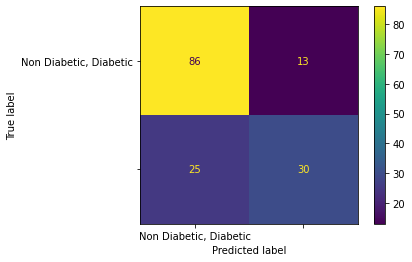

In [63]:
plot_confusion_matrix(grid_best_estimator, X_test, y_test, display_labels=['Non Diabetic, Diabetic'], values_format='d')

## Automated Hyperparameter Tuning
> Automated Hyperparameter Tuning can be done by using techniques such as
- Bayesian Optimization
- Gradient Descent
- Evolutionary Algorithms

> ### Bayesian Optimization
Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which gives us the lowest possible output value. It usually performs better than random, grid and manual search providing better performance in the testing phase and reduced optimization time. In `Hyperopt`, `Bayesian Optimization` can be implemented giving 3 three main parameters to the function `fmin`.
- `Objective Function` = defines the loss function to minimize.
- `Domain Space` = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- `Optimization Algorithm` = defines the search algorithm to use to select the best input values to use in each new iteration.

In [67]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
    }

In [68]:
space

{'criterion': <hyperopt.pyll.base.Apply at 0x7fabd80aca10>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7fabd8146d90>,
 'max_features': <hyperopt.pyll.base.Apply at 0x7fabd9019590>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x7fabd809df10>,
 'min_samples_split': <hyperopt.pyll.base.Apply at 0x7fabd80ab4d0>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x7fabd80ab9d0>}

In [70]:
def objective(space):
    model = RandomForestClassifier(criterion=space['criterion'], 
                                   max_depth=space['max_depth'],
                                   max_features = space['max_features'],
                                   min_samples_leaf = space['min_samples_leaf'],
                                   min_samples_split = space['min_samples_split'],
                                   n_estimators = space['n_estimators'])
    accuracy = cross_val_score(model, X_train, y_train, cv=5).mean()
    return {'loss': -accuracy, 'status': STATUS_OK}

In [72]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=80,
            trials=trials)
best

100%|██████████| 80/80 [06:45<00:00,  5.07s/it, best loss: -0.7752765560442489]


{'criterion': 0,
 'max_depth': 470.0,
 'max_features': 3,
 'min_samples_leaf': 0.05735694699107302,
 'min_samples_split': 0.04495160574878883,
 'n_estimators': 6}

In [73]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}

print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

entropy
None
1500


In [74]:
best['min_samples_leaf']

0.05735694699107302

In [75]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,y_train)
pred_forest = trainedforest.predict(X_test)

In [76]:
confusion_matrix(y_test, pred_forest)

array([[85, 14],
       [27, 28]])

In [77]:
accuracy_score(y_test, pred_forest)

0.7337662337662337

In [78]:
print(classification_report(y_test, pred_forest))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81        99
           1       0.67      0.51      0.58        55

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



## Genetic Algorithms
> Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts.

> Let's immagine we create a population of N Machine Learning models with some predifined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best). We can now generate some offsprings having similar Hyperparameters to the ones of the best models so that go get again a population of N models. At this point we can again caltulate the accuracy of each model and repeate the cycle for a defined number of generations. In this way, just the best models will survive at the end of the process

In [83]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(10, 1000, 10)]
min_samples_split = [2, 5, 10, 14]
min_samples_leaf = [1, 2, 4, 6, 8]

param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [84]:
tpot_classifier = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(X_train,y_train)


Generation 1 - Current best internal CV score: 0.7785735506323741

Generation 2 - Current best internal CV score: 0.7785735506323741

Generation 3 - Current best internal CV score: 0.7785735506323741

Generation 4 - Current best internal CV score: 0.7801863169510228

Generation 5 - Current best internal CV score: 0.7801863169510228

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=gini, max_depth=890, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1200)


TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['entropy',
                                                                                      'gini'],
                                                                        'max_depth': [10,
                                                                                      120,
                                                                                      230,
                                                                                      340,
                                                                                      450,
                                                                                      560,
                                                                                      670,
                                                                                      780,
                                                                                 

In [85]:
tpot_classifier.score(X_test, y_test)

0.7337662337662337

## Optimize hyperparameters of the  model using Optuna
> The hyperparameters of the above algorithm are n_estimators and max_depth for which we can try different values to see if the model accuracy can be improved. The objective function is modified to accept a trial object. This trial has several methods for sampling hyperparameters. We create a study to run the hyperparameter optimization and finally read the best hyperparameters.

In [87]:
def objective(trial):
    classifier = trial.suggest_categorical('classifier', ['RandomForest', 'SVC'])
    
    if classifier == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 200, 2000,10)
        max_depth = int(trial.suggest_float('max_depth', 10, 100, log=True))

        clf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth)
    else:
        c = trial.suggest_float('svc_c', 1e-10, 1e10, log=True)
        
        clf = sklearn.svm.SVC(C=c, gamma='auto')

    return sklearn.model_selection.cross_val_score(
        clf,X_train,y_train, n_jobs=-1, cv=3).mean()

In [88]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2021-03-25 20:10:54,245] A new study created in memory with name: no-name-c496da7f-1ba4-4554-8df2-8e76942e8e43
[I 2021-03-25 20:10:56,146] Trial 0 finished with value: 0.6530926191614858 and parameters: {'classifier': 'SVC', 'svc_c': 115754765.4127412}. Best is trial 0 with value: 0.6530926191614858.
[I 2021-03-25 20:11:04,578] Trial 1 finished with value: 0.7639008448908019 and parameters: {'classifier': 'RandomForest', 'n_estimators': 1560, 'max_depth': 13.460718344263816}. Best is trial 1 with value: 0.7639008448908019.
[I 2021-03-25 20:11:04,633] Trial 2 finished with value: 0.6530926191614858 and parameters: {'classifier': 'SVC', 'svc_c': 2.1774207136818704e-08}. Best is trial 1 with value: 0.7639008448908019.
[I 2021-03-25 20:11:04,707] Trial 3 finished with value: 0.6530926191614858 and parameters: {'classifier': 'SVC', 'svc_c': 37781116.97851339}. Best is trial 1 with value: 0.7639008448908019.
[I 2021-03-25 20:11:10,072] Trial 4 finished with value: 0.7655268611509646 and p

Accuracy: 0.7736728837876615
Best hyperparameters: {'classifier': 'RandomForest', 'n_estimators': 1760, 'max_depth': 10.22293214257382}


In [90]:
trial

FrozenTrial(number=24, values=[0.7736728837876615], datetime_start=datetime.datetime(2021, 3, 25, 20, 13, 16, 489995), datetime_complete=datetime.datetime(2021, 3, 25, 20, 13, 25, 344931), params={'classifier': 'RandomForest', 'n_estimators': 1760, 'max_depth': 10.22293214257382}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest', 'SVC')), 'n_estimators': IntUniformDistribution(high=2000, low=200, step=10), 'max_depth': LogUniformDistribution(high=100.0, low=10.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=24, state=TrialState.COMPLETE, value=None)

In [91]:
study.best_params

{'classifier': 'RandomForest',
 'max_depth': 10.22293214257382,
 'n_estimators': 1760}

In [92]:
rf=RandomForestClassifier(n_estimators=330,max_depth=30)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=330,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [93]:
y_pred=rf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[86 13]
 [21 34]]
0.7792207792207793
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        99
           1       0.72      0.62      0.67        55

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.78      0.78      0.77       154



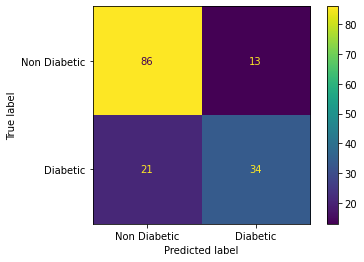

In [94]:
plot_confusion_matrix(rf, X_test, y_test, display_labels=['Non Diabetic', 'Diabetic'], values_format='d')